# Assignment 2 - Epipolar Geometry and 3D Reconstruction 

First name:Gerig
<br>
Last name: Pascal
<br>
Matriculation number: 16-104-721

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
from PIL import Image
import ipyvolume as ipv
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr

from utils import decompose_essential_matrix, infer_3d, ransac

## Part II: 3D Model Reconstruction

### Load matched points
We provide a synthetic pair of images where noisy correspondences are known.

In [2]:
left = np.array(Image.open(os.path.join('MatchedPoints','left.jpg')), dtype=np.float32).mean(2)/255
right = np.array(Image.open(os.path.join('MatchedPoints','right.jpg')), dtype=np.float32).mean(2)/255

Text(0.5, 1.0, 'Right image')

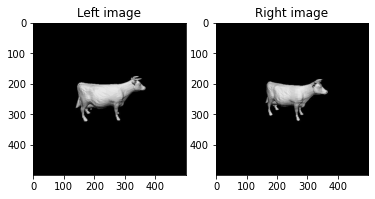

In [3]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.title('Left image')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.title('Right image')

In [4]:
ilias_username = "z.m.matti" # TODO
#ilias_username = "gerig.pascal.dominik" # TODO

A = np.loadtxt(f'MatchedPoints/Matched_Points_{ilias_username}.txt')

In [5]:
M, N = A.shape
leftPoints = np.concatenate((A[:,2:4].T, np.ones((1, M))), axis=0)
rightPoints = np.concatenate((A[:,0:2].T, np.ones((1, M))), axis=0)

### Calibration matrix and focal length from the given file

In [6]:
fl = 4
K = np.array([
    [-83.33333, 0.00000, 250.00000],
    [0.00000, -83.33333, 250.00000],
    [0.00000, 0.00000,   1.00000],
])

I = K.copy()

I[0,0] *= fl
I[1,1] *= fl

### Estimate Essential matrix E from F with RANSAC

In [24]:
good_threshold = 1 # TODO
F, inliers = ransac(leftPoints, rightPoints, good_threshold)
print('Num outliers', leftPoints.shape[1] - inliers.sum())
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

# TODO: Estimate essential matrix E from F
E = I.T @ F @ I

print('Estimated essential matrix: ')
print(E)

Num outliers 3
Estimated fundamental matrix: 
[[ 6.41789730e-08  1.93203495e-05 -7.48953467e-03]
 [ 3.34441230e-07 -2.71349095e-06 -1.82534816e-02]
 [-8.40377637e-05  1.36538859e-02  1.98019974e+00]]
Estimated essential matrix: 
[[ 7.13099642e-03  2.14670533e+00  8.81134148e-01]
 [ 3.71601337e-02 -3.01498971e-01  6.28274775e+00]
 [-5.20576219e-03 -5.93519996e+00 -2.49848965e-04]]


### Compute rotation and translation between views

In [25]:
# TODO: Compute rotation and translation between views. Complete decomposeE
Il = np.linalg.solve(I, leftPoints[:, inliers])
Ir = np.linalg.solve(I, rightPoints[:, inliers])

Pl, Pr = decompose_essential_matrix(E, Il, Ir)

print('Estimated translation: ')
print(Pr[:,3])
print('Estimated rotation: ')
print(Pr[:,:3])

Estimated translation: 
[ 0.93020688 -0.13044473  0.34307336]
Estimated rotation: 
[[ 9.28288103e-01  1.38077748e-01 -3.45276315e-01]
 [-1.29289899e-01  9.90421329e-01  4.84738473e-02]
 [ 3.48662186e-01 -3.56955807e-04  9.37248394e-01]]


### Estimate the 3D points

In [26]:
x3D = infer_3d(Il, Ir, Pl, Pr)
ipv.quickscatter(x=x3D[0,:], y=x3D[1,:], z=x3D[2,:])